# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings
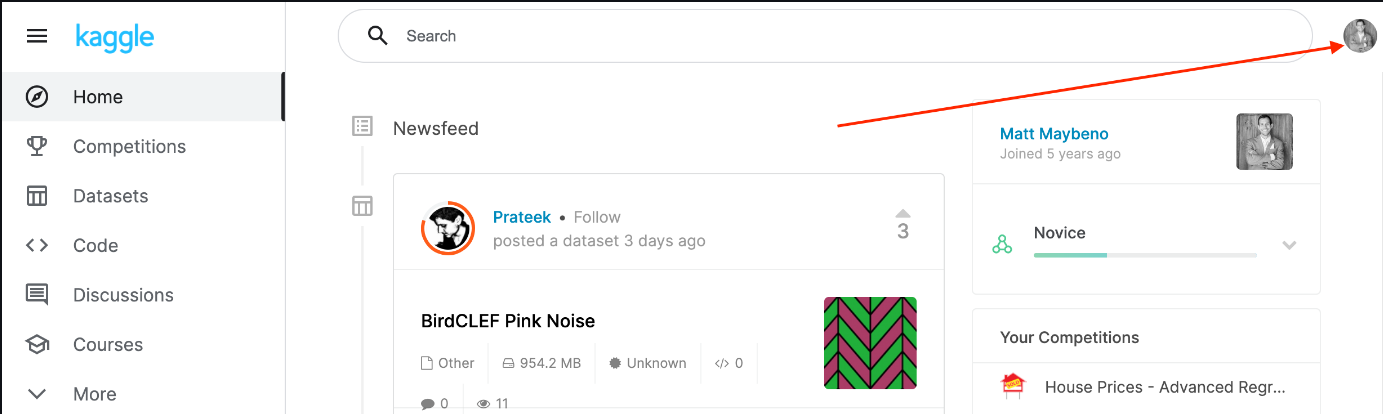
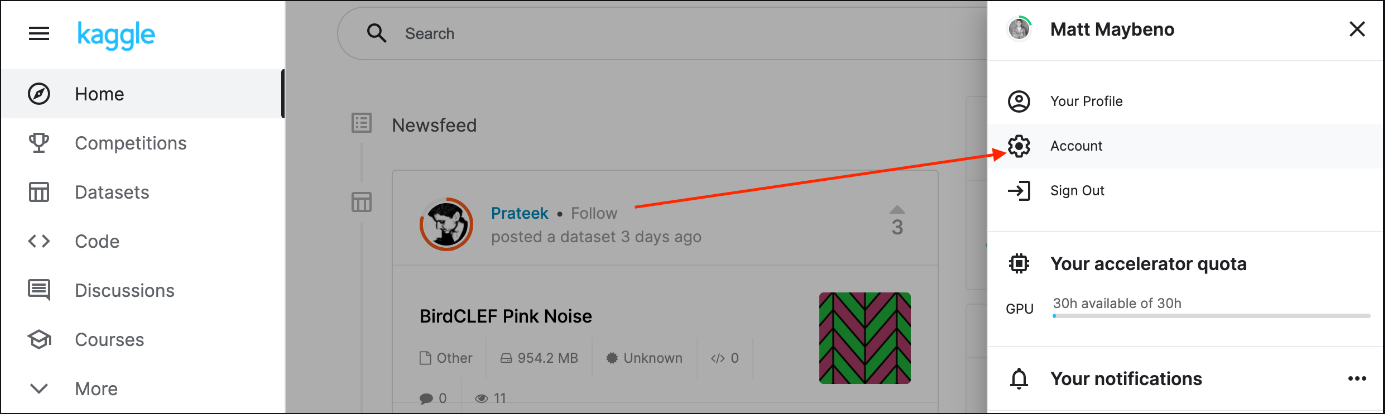
2. Scroll down to API and click Create New API Token
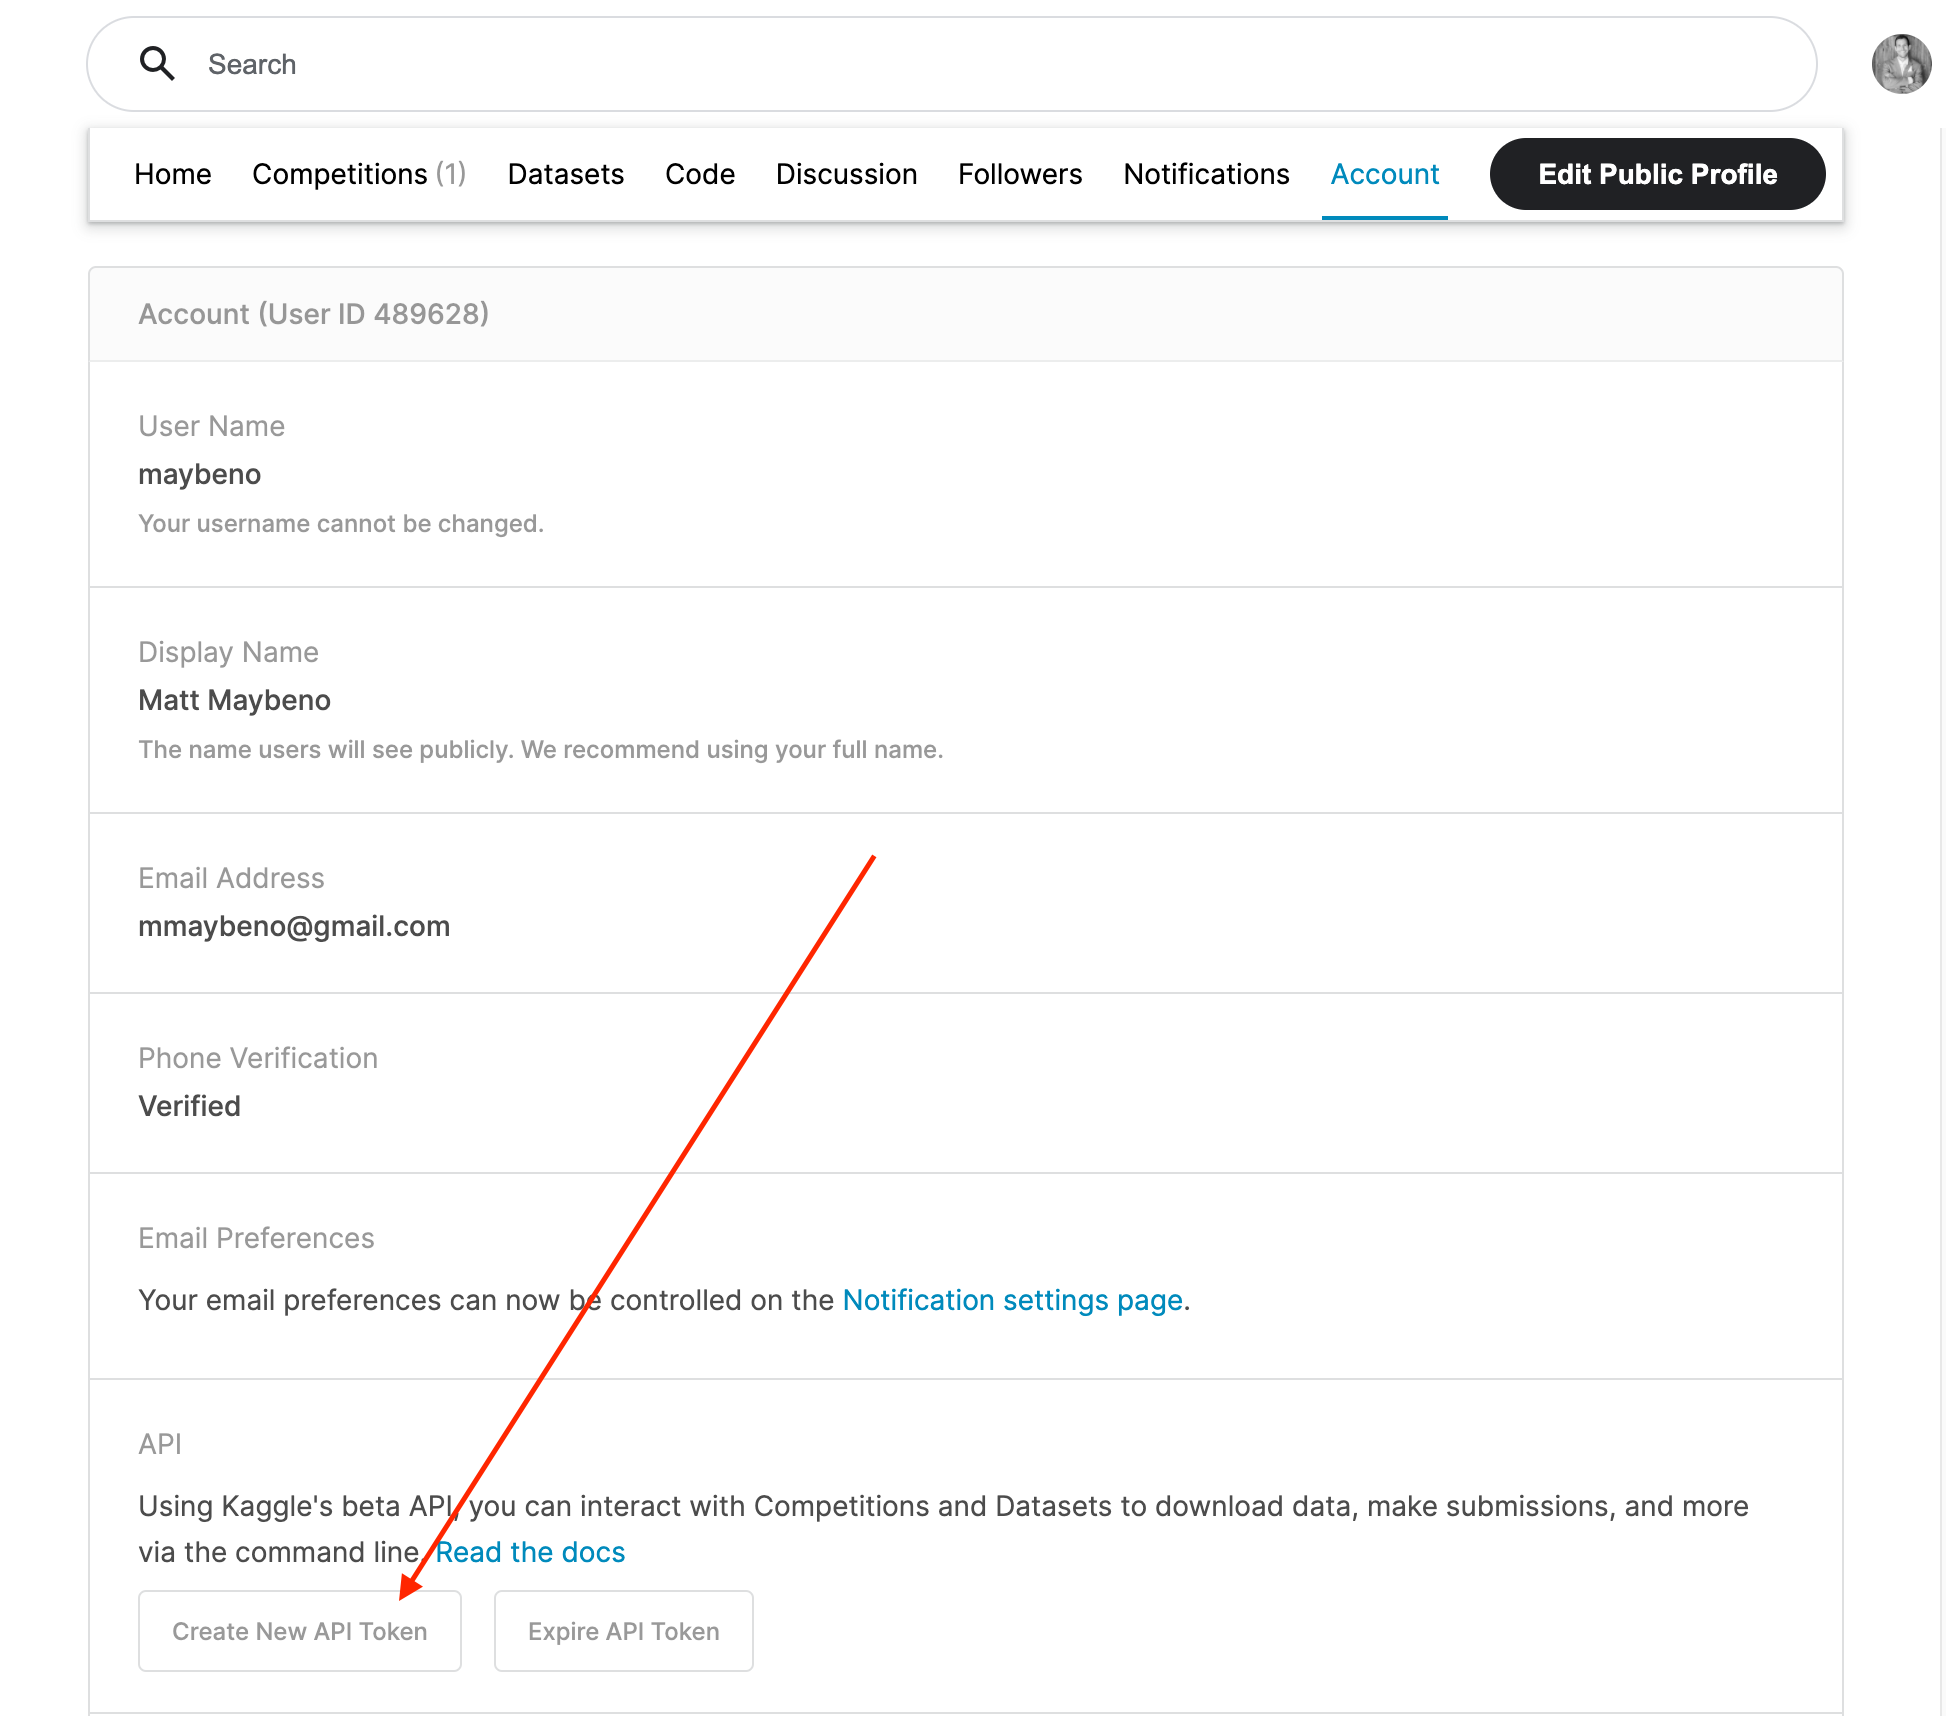
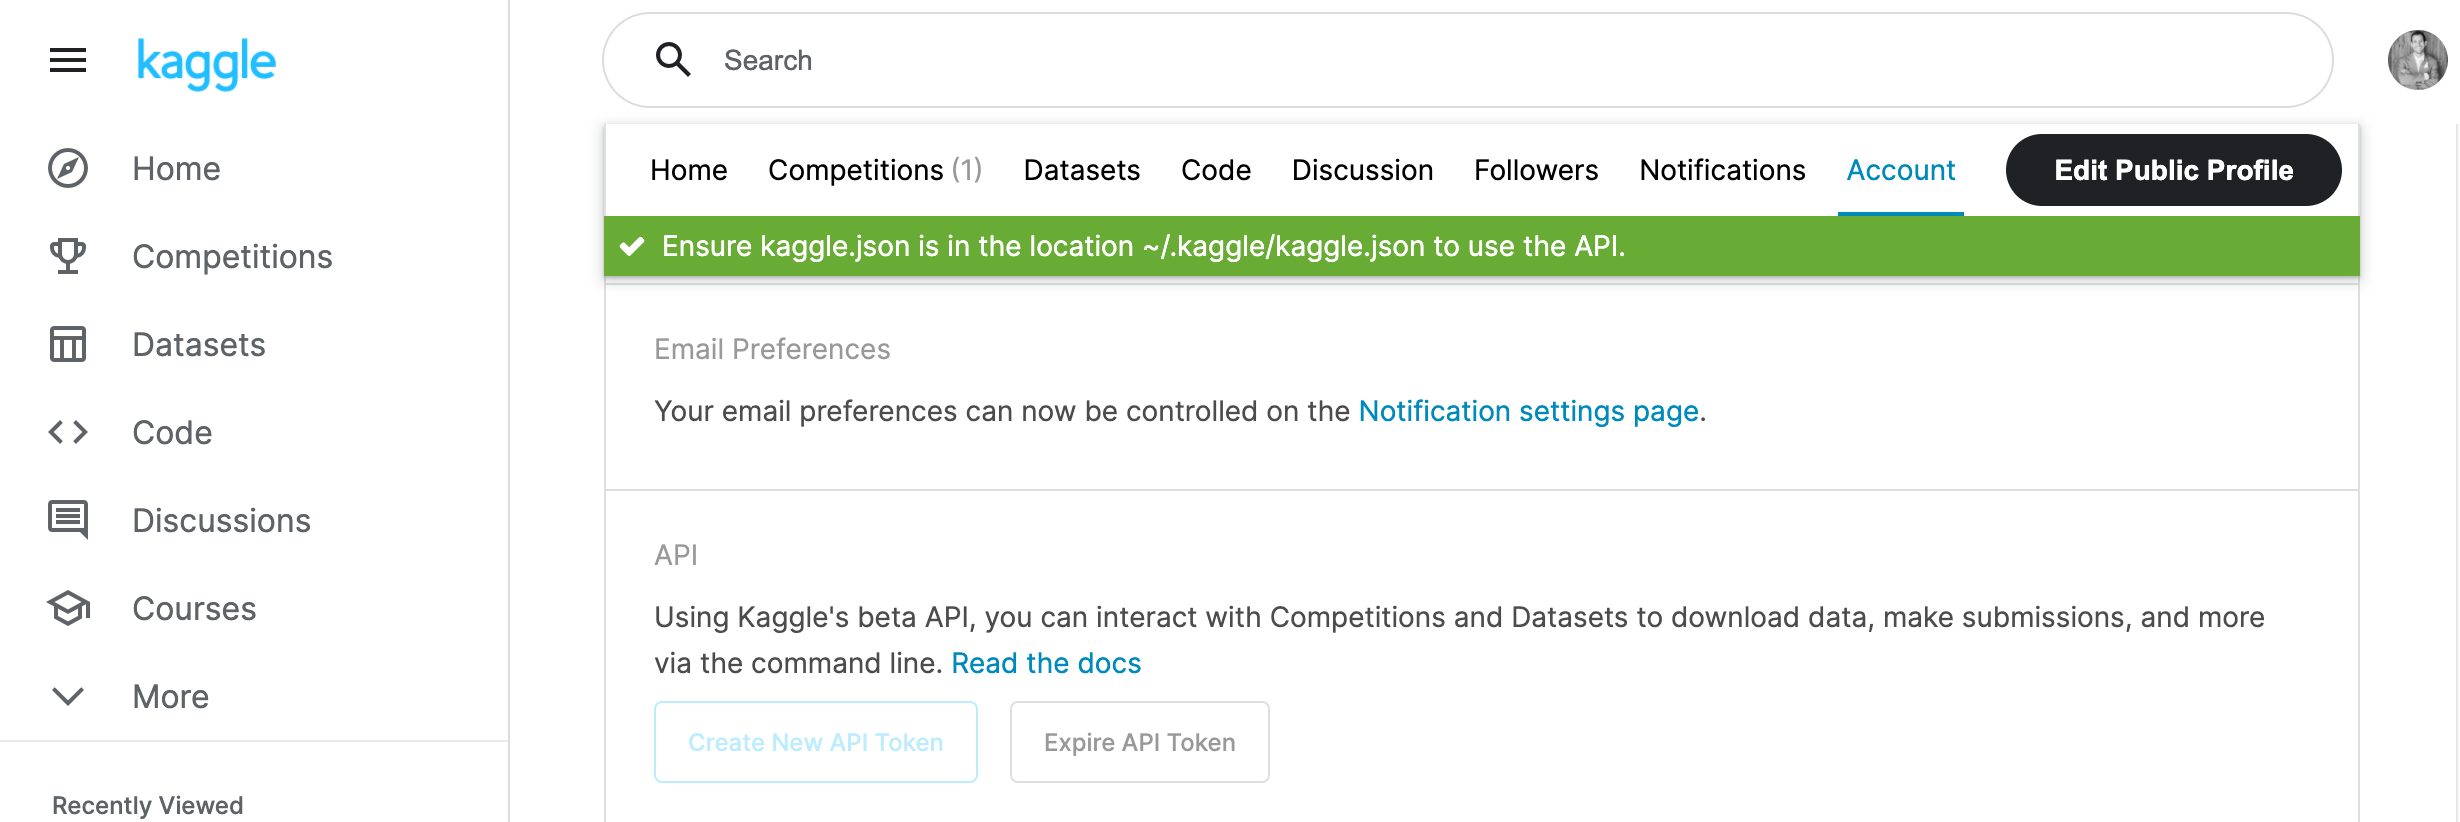
3. Open up kaggle.json and use the username and key.
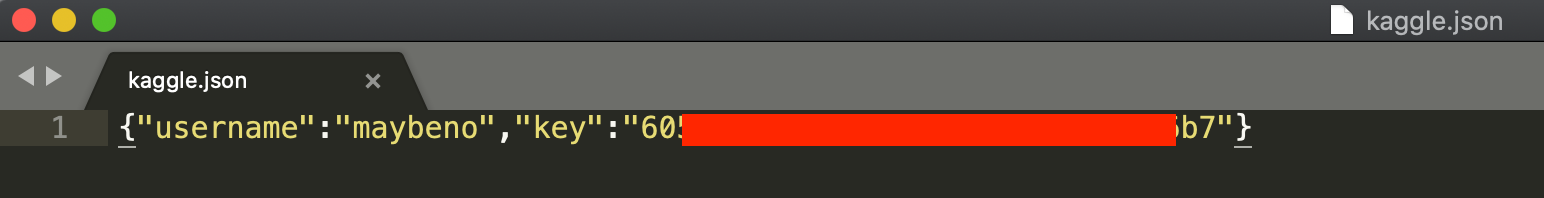

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [1]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.1/953.1 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 69.5.1
    Uninstalling setuptools-69.5.1:
      Successfully uninstalled setuptools-69.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
cvxpy 1.3.4 requires setuptools>65.5.1, but you have setuptools 60.2.0 which is incompatible.


### Setup Kaggle API Key

In [2]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
# Fill in your user name and key from creating the kaggle account and API token file
from google.colab import userdata
import json
kaggle_username = userdata.get('username')
kaggle_key = userdata.get('key')

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms
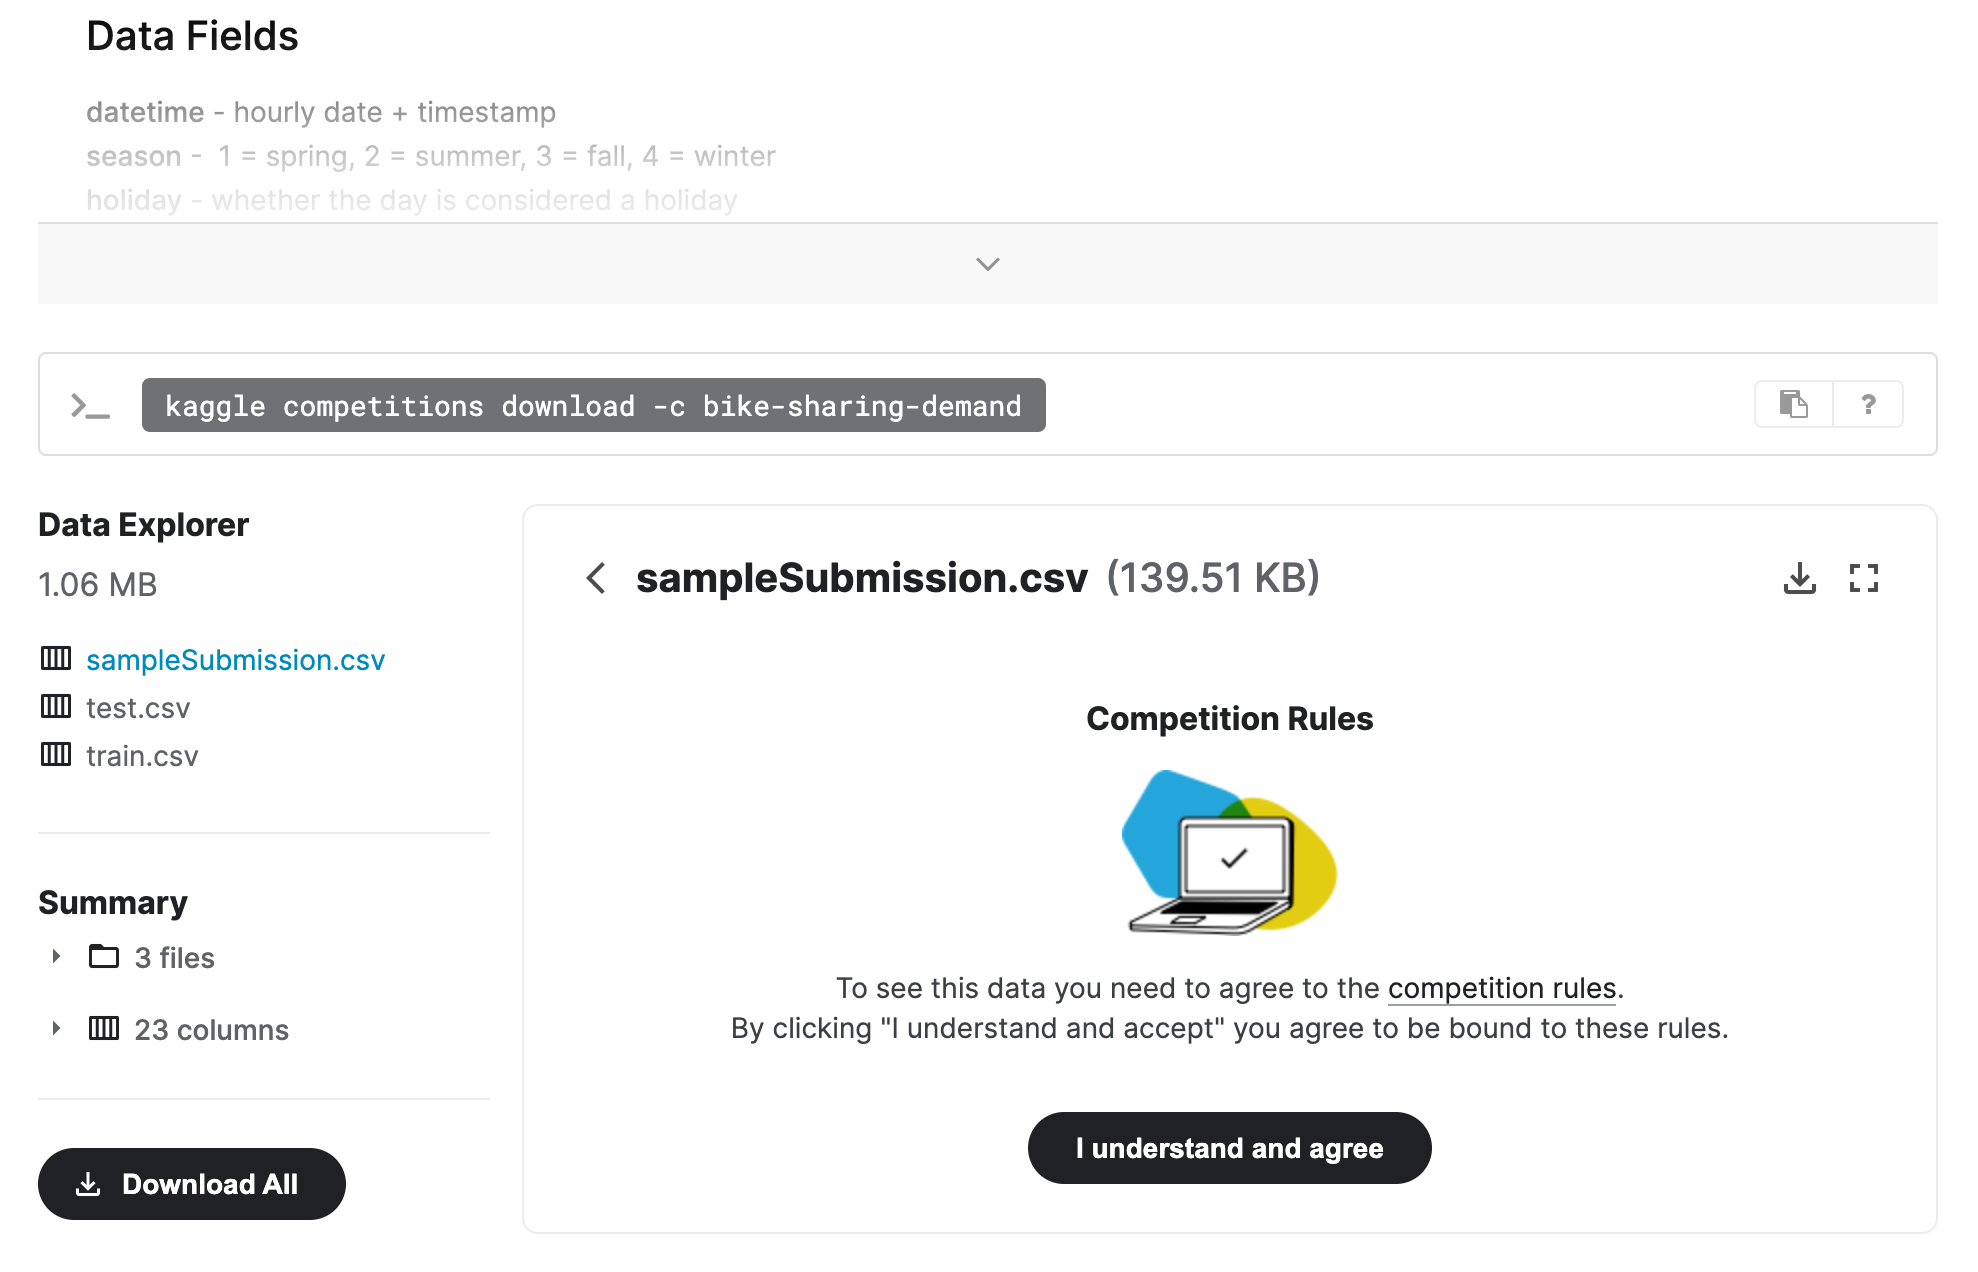

In [4]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

  0% 0.00/189k [00:00<?, ?B/s]
100% 189k/189k [00:00<00:00, 107MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [5]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [6]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("/content/train.csv", parse_dates=["datetime"])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [7]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe().round(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00
mean,2011-12-27 05:56:22.399411968,2.51,0.03,0.68,1.42,20.23,23.66,61.89,12.80,36.02,155.55,191.57
min,2011-01-01 00:00:00,1.00,0.00,0.00,1.00,0.82,0.76,0.00,0.00,0.00,0.00,1.00
25%,2011-07-02 07:15:00,2.00,0.00,0.00,1.00,13.94,16.66,47.00,7.00,4.00,36.00,42.00
50%,2012-01-01 20:30:00,3.00,0.00,1.00,1.00,20.50,24.24,62.00,13.00,17.00,118.00,145.00
75%,2012-07-01 12:45:00,4.00,0.00,1.00,2.00,26.24,31.06,77.00,17.00,49.00,222.00,284.00
max,2012-12-19 23:00:00,4.00,1.00,1.00,4.00,41.00,45.46,100.00,57.00,367.00,886.00,977.00
std,NaN,1.12,0.17,0.47,0.63,7.79,8.47,19.25,8.16,49.96,151.04,181.14


In [8]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("/content/test.csv", parse_dates=["datetime"])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [15]:
# Same thing as train and test dataset
submission = pd.read_csv("/content/sampleSubmission.csv")
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset.
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [9]:
predictor = TabularPredictor(label="count", eval_metric="root_mean_squared_error", learner_kwargs={'ignored_columns': ['casual','registered']}).fit(
    train_data=train,
    time_limit=600, presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240428_135114"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240428_135114/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 197 seconds

### Review AutoGluon's training run with ranking of models that did the best.

In [10]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -53.122595  root_mean_squared_error      24.717258  401.776380                0.000958           0.038831            3       True         12
1   RandomForestMSE_BAG_L2  -53.402586  root_mean_squared_error      17.956331  301.354815                0.716811          47.976553            2       True         11
2          LightGBM_BAG_L2  -55.147707  root_mean_squared_error      17.566118  285.738004                0.326599          32.359741            2       True         10
3        LightGBMXT_BAG_L2  -60.584292  root_mean_squared_error      23.672890  321.401254                6.433371          68.022992            2       True          9
4    KNeighborsDist_BAG_L1  -84.125061  root_mean_squared_error       0.097227    0.047281   

/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -116.54835939455667,
  'CatBoost_BAG_L1': -130.98651546214953,
  'ExtraTreesMSE_BAG_L1': -124.60067564699747,
  'WeightedEnsemble

### Create predictions from test dataset

In [11]:
predictions = predictor.predict(test)
predictions.head()

0    23.621536
1    42.814308
2    45.988480
3    48.937813
4    52.053276
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [12]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe().round(2)

count    6493.00
mean      100.59
std        89.91
min         3.01
25%        19.99
50%        64.16
75%       168.15
max       368.34
Name: count, dtype: float64

In [13]:
# How many negative values do we have?
negative_count = (predictions < 0).sum()
print(f"Number of negative values: {negative_count}")

Number of negative values: 0


In [ ]:
# Set them to zero

### Set predictions to submission dataframe, save, and submit

In [16]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [17]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100% 188k/188k [00:00<00:00, 432kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [22]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2024-04-28 14:31:24  first raw submission               complete  1.80293      1.80293       
submission_new_hpo.csv       2024-04-22 13:07:03  new features with hyperparameters  error                                
submission_new_hpo.csv       2024-04-22 12:54:14  new features with hyperparameters  error                                


#### Initial score of `1.80293`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'holiday'}>],
       [<Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'weather'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'casual'}>,
        <Axes: title={'center': 'registered'}>,
        <Axes: title={'center': 'count'}>]], dtype=object)

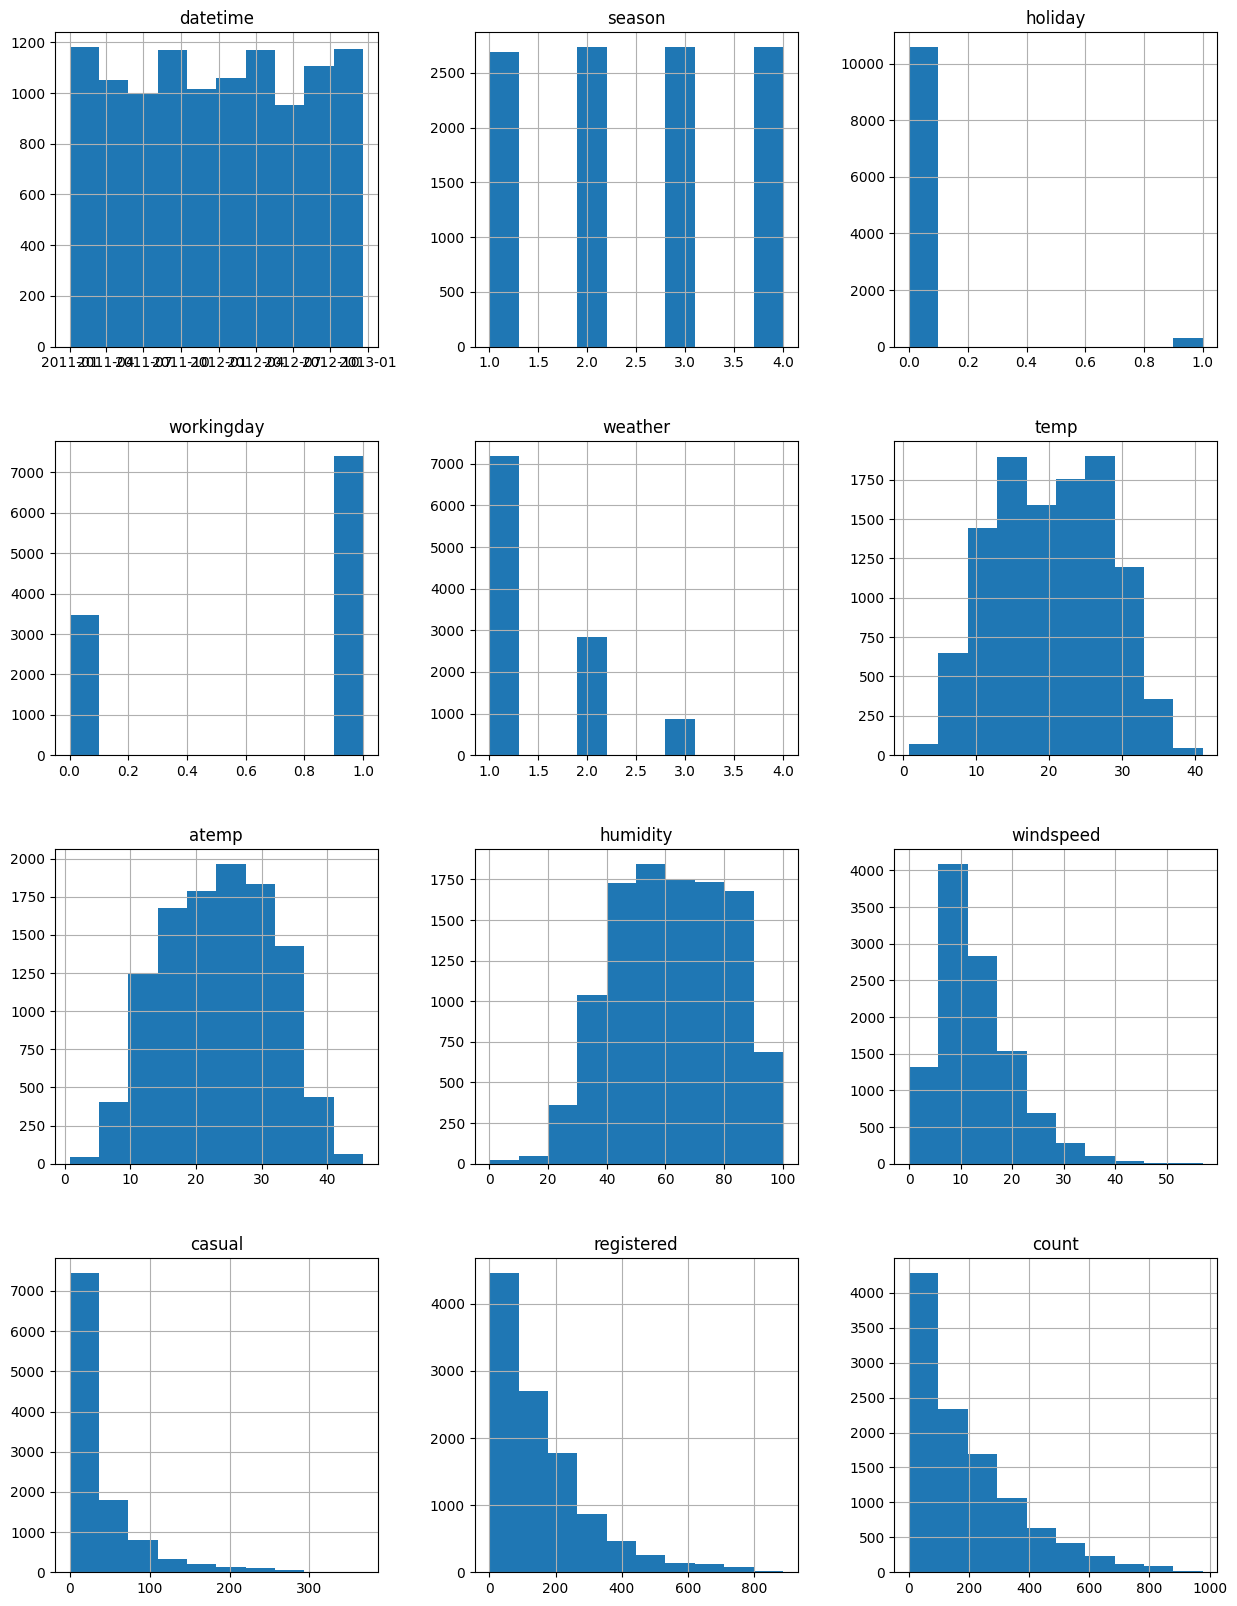

In [23]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(15, 20))

In [28]:
# create a new feature
train["hour"] = train["datetime"].dt.hour
test["hour"] = test["datetime"].dt.hour
train["dayofweek"] = train["datetime"].dt.dayofweek
test["dayofweek"] = test["datetime"].dt.dayofweek

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [29]:
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")

In [30]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,5


array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'workingday'}>],
       [<Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>],
       [<Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'casual'}>,
        <Axes: title={'center': 'registered'}>],
       [<Axes: title={'center': 'count'}>,
        <Axes: title={'center': 'hour'}>,
        <Axes: title={'center': 'dayofweek'}>]], dtype=object)

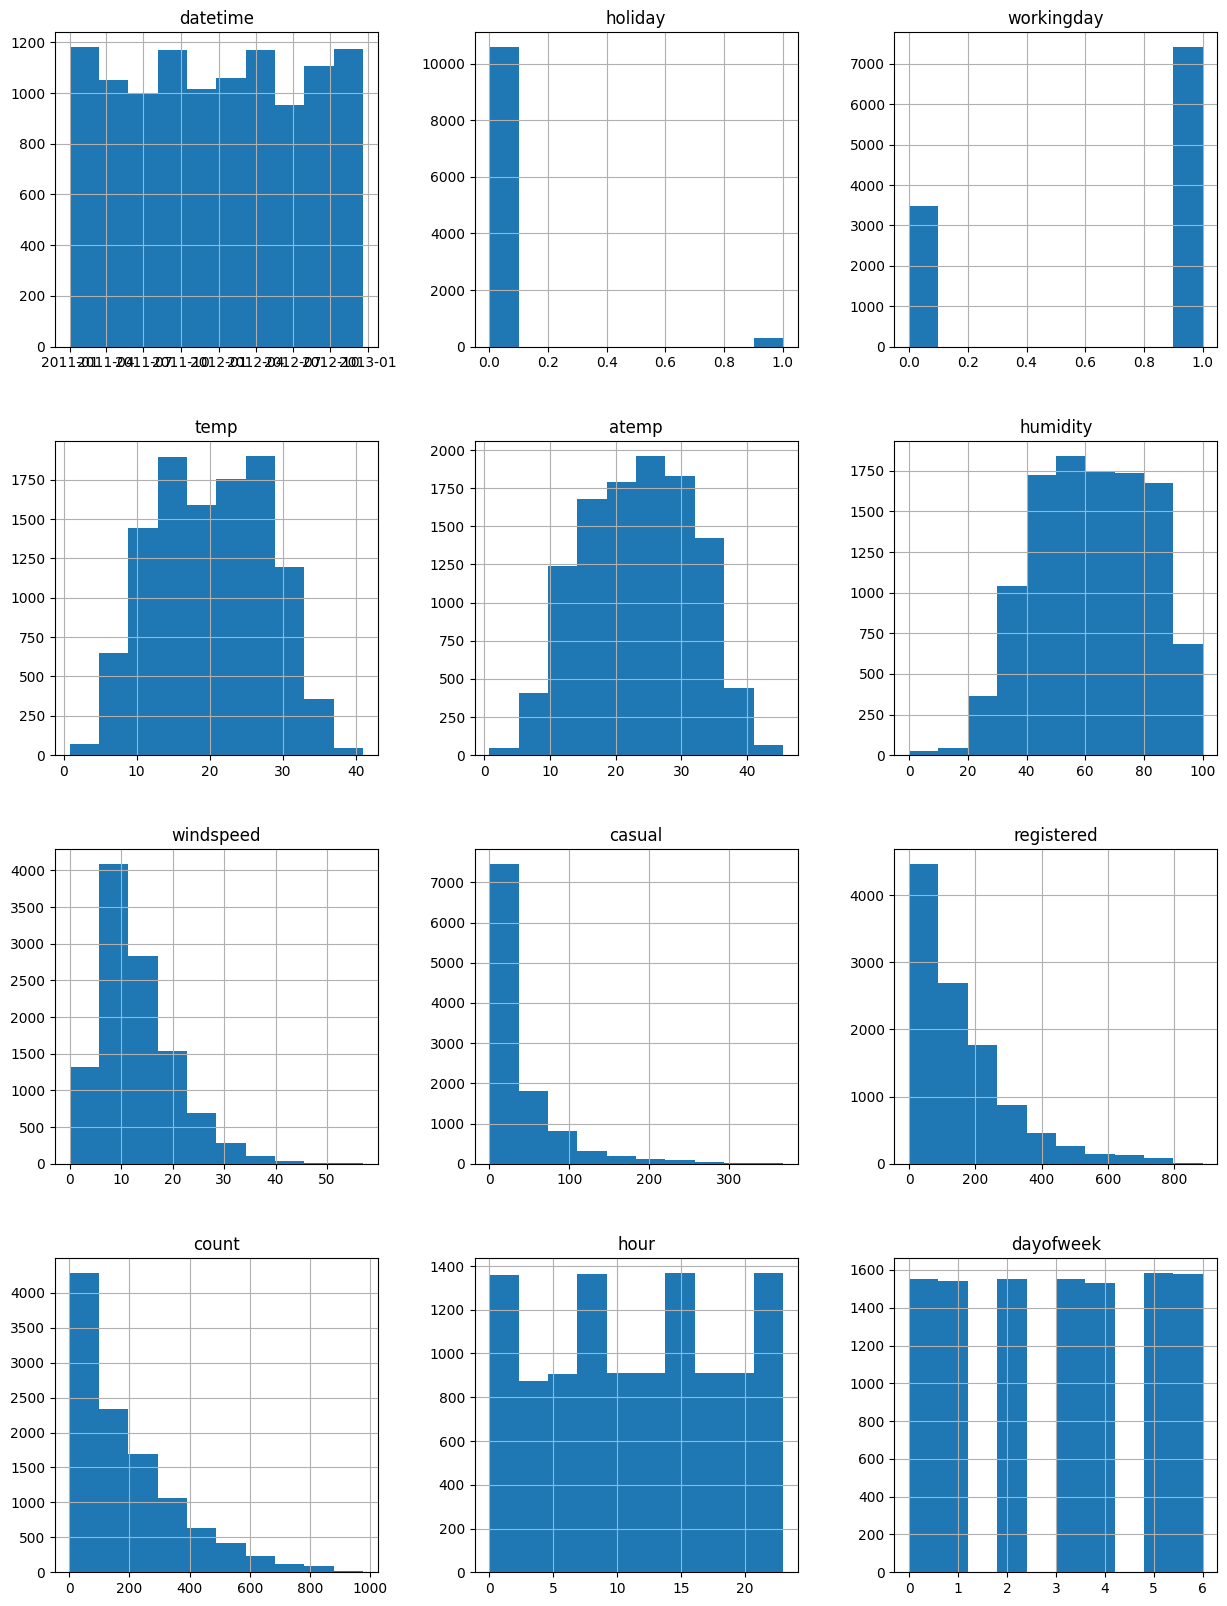

In [31]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(15, 20))

## Step 5: Rerun the model with the same settings as before, just with more features

In [32]:
predictor_new_features = TabularPredictor(label="count", eval_metric="root_mean_squared_error", learner_kwargs={'ignored_columns': ['casual','registered']}).fit(
    train_data=train,
    time_limit=600,
    presets="best_quality"
)


No path specified. Models will be saved in: "AutogluonModels/ag-20240428_144841"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240428_144841/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 195 seconds

In [33]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.412034  root_mean_squared_error      41.344650  384.408176                0.000866           0.033949            3       True         11
1          LightGBM_BAG_L2  -30.707747  root_mean_squared_error      38.515739  294.014188                0.488906          33.806998            2       True          9
2        LightGBMXT_BAG_L2  -31.122288  root_mean_squared_error      39.910939  303.946764                1.884106          43.739574            2       True          8
3   RandomForestMSE_BAG_L2  -31.865057  root_mean_squared_error      38.970772  306.827655                0.943939          46.620465            2       True         10
4      WeightedEnsemble_L2  -32.351679  root_mean_squared_error      37.796154  214.404843   

/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -34.51969073256383,
  'LightGBM_BAG_L1': -33.919639163586254,
  'RandomForestMSE_BAG_L1': -38.39829569179141,
  'CatBoost_BAG_L1': -39.69402556816375,
  'WeightedEnsemble_L2': -32.351679225126645,
  'LightGBMXT_BAG_L2': -31.12228827929147,
  'LightGBM_BAG_L2': -30.707747

In [34]:
# Remember to set all negative values to zero
submission["count"] = submission["count"].apply(lambda x: 0 if x < 0 else x)

In [35]:
# Same submitting predictions
submission_new_features = pd.read_csv('submission.csv')
submission_new_features["count"] = predictor_new_features.predict(test)
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [36]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100% 188k/188k [00:00<00:00, 453kB/s]
Successfully submitted to Bike Sharing Demand

In [37]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2024-04-28 15:03:21  new features                       complete  0.61673      0.61673       
submission.csv               2024-04-28 14:31:24  first raw submission               complete  1.80293      1.80293       
submission_new_hpo.csv       2024-04-22 13:07:03  new features with hyperparameters  error                                


#### New Score of `0.61673`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [73]:
from autogluon.common import space

# Neural network (NN) options

nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 10,  # number of training epochs (controls training time of NN models)
    'learning_rate': space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'dropout_prob': space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
    'optimizer': space.Categorical("adam", "sgd", "rmsprop"),
}

# LightGBM (GBM) options
gbm_options = {
    'num_boost_round': 150,  # Number of boosting rounds
    'num_leaves': space.Int(lower=26, upper=66, default=36), # Number of leaves in trees
    'leraning_rate': 0.05,

}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN_TORCH': nn_options,
                  }

hyperparameter_tune_kwargs = {
    'num_trials': 10,
    'scheduler' : 'local',
    'searcher': 'auto',
}

predictor_new_hpo = TabularPredictor(label="count", eval_metric="root_mean_squared_error").fit(
    train_data=train.drop(["casual", "registered"], axis=1),
    time_limit=600,
    presets="best_quality",
    hyperparameters=hyperparameters,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
)


No path specified. Models will be saved in: "AutogluonModels/ag-20240428_170604"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240428_170604/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 70 seconds 

  0%|          | 0/10 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.08%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.08%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.10%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.07%)
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L1/T1 ...
	-37.7519	 = Validation score   (-root_mean_squared_error)
	32.17s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T2 ...
	-37.2657	 = Validation score   (-root_mean_squared_error)
	32.53s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T3 ...
	-36.4705	 = Validation score   (-root_mean_squared_error)
	32.57s	 = Training   run

  0%|          | 0/10 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.10%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.09%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.13%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.09%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.11%)
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L2/T1 ...
	-35.6221	 = Validation score   (-root_mean_squared_error)
	31.78s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L2/T2 ...
	-35.7617	 = Validation score   (-root_mean_squared_error)
	31.84s	 = Training   runtime
	0.0s	 = Validat

In [74]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L3  -35.335276  root_mean_squared_error       0.006759  224.502351                0.001568           0.053509            3       True         11
1    LightGBM_BAG_L2/T1  -35.622128  root_mean_squared_error       0.004291  160.022842                0.000177          31.784266            2       True          6
2    LightGBM_BAG_L2/T3  -35.683141  root_mean_squared_error       0.004826  160.823649                0.000712          32.585073            2       True          8
3    LightGBM_BAG_L2/T5  -35.755653  root_mean_squared_error       0.004338  163.727350                0.000224          35.488774            2       True         10
4    LightGBM_BAG_L2/T2  -35.761675  root_mean_squared_error       0.004302  160.079501                0.000

/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T4': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T4': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T5': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBM_BAG_L1/T1': -37.751921766362045,
  'LightGBM_BAG_L1/T2': -37.26570855884233,
  'LightGBM_BAG_L1/T3': -36.47049796019334,
  'LightGBM_BAG_L1/T4': -100.4571879326306,
  'WeightedEnsemble_L2': -36.12120433159464,
  'LightGBM_BAG_L2/T1': -35.622128249316475,
  'LightGBM_BAG_L2/T2': -35.7616750059766,
  'LightGBM_BAG_L2/T3': -35.68314120942161,
  'LightGBM_BAG_L2/T4': -79.1877327656571

In [75]:
# Remember to set all negative values to zero

submission_new_hpo = pd.read_csv('submission.csv')
submission_new_hpo["count"] = predictor_new_hpo.predict(test)
submission_new_hpo["count"] = submission_new_hpo["count"].apply(lambda x: 0 if x < 0 else x)
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)


In [77]:
# Remember to set all negative values to zero
submission["count"] = submission["count"].apply(lambda x: 0 if x < 0 else x)


In [78]:
# Same submitting predictions
submission_new_hpo = pd.read_csv('submission_new_features.csv')
submission_new_hpo["count"] = predictor_new_hpo.predict(test)
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [79]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100% 188k/188k [00:00<00:00, 382kB/s]
Successfully submitted to Bike Sharing Demand

In [80]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2024-04-28 17:35:01  new features with hyperparameters  complete  0.47712      0.47712       
submission_new_features.csv  2024-04-28 15:03:21  new features                       complete  0.61673      0.61673       
submission.csv               2024-04-28 14:31:24  first raw submission               complete  1.80293      1.80293       


#### New Score of `0.47712`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

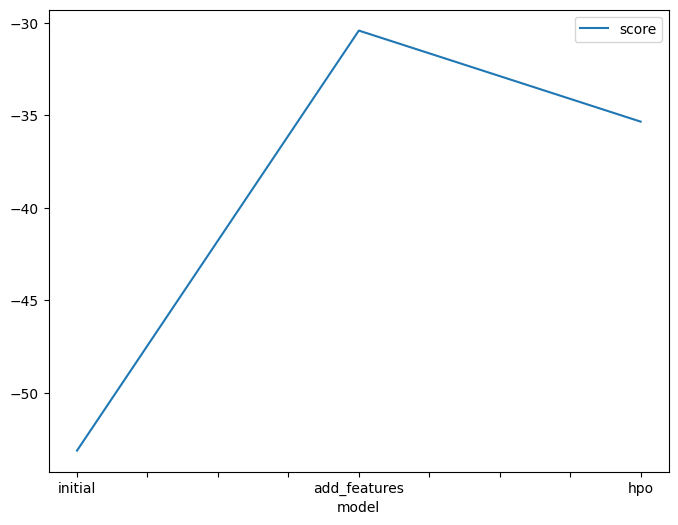

In [82]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [-53.122595, -30.412034, -35.335276]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')


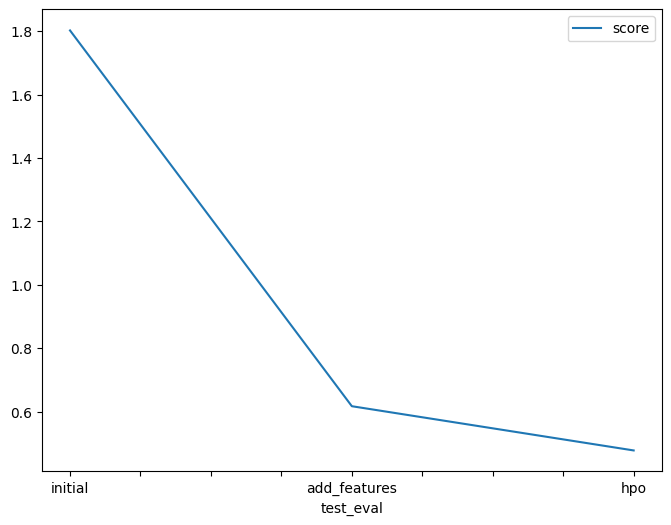

In [81]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.80293, 0.61673,  0.47712]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [4]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ["default", "default", "num_boost_round"],
    "hpo2": ["default", "default", "learning_rate"],
    "hpo3": ["default", "default", "scheduler"],
    "score": [1.80293, 0.61673,  0.47712]
})

,model,hpo1,hpo2,hpo3,score
0,initial,default,default,default,1.80293
1,add_features,default,default,default,0.61673
2,hpo,num_boost_round,learning_rate,scheduler,0.47712
